### Estimating thermodynamic sea-ice growth during the breakup event 

#### Author: Jonathan Rheinlænder*
#### Date: Jun. 02 2022
#### Affiliation: Nansen Environmental and Remote Sensing Center, Bergen, Norway
*jonathan.rheinlaender@nersc.no

In [1]:

%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import struct
import xarray as xr
from datetime import datetime
import matplotlib as mpl
import sys
import os
import datetime as dt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.inset_locator import inset_axes

from pynextsim.projection_info import ProjectionInfo

import matplotlib.dates as mdates
import pandas as pd
import cmocean as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from shapely.geometry.polygon import Polygon
import matplotlib.patches as mpatches

import eval_metrics
import calc_leadfrac
from calc_IceGrowth_2013breakup import IceGrowth

<ipython-input-1-29249acf2565>:14: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes


In [2]:
# environment variables
rootdir = '/home/rheinlender/shared-simstore-ns9829k/'
inpath = rootdir + 'home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/'
obsdir = rootdir + 'data/'
outpath_plots =  rootdir + 'home/rheinlender/figs/breakup-paper/'

sys.path.append(rootdir + '/home/rheinlender/NANUK/') 


# Ice volume growth estimates for all expts

In [3]:
expts = ["expt_01_wrf10/outputs/", 
         "expt_02_wrf20/outputs/",
         "expt_03_wrf40/outputs/",
         "expt_04_wrf80/outputs/", 
         "expt_05_wrf10-sitx0.5/outputs/",
         "expt_06_wrf10-sitx1.5/outputs/", 
         "expt_07_wrf10-sitx2.0/outputs/",
         "expt_01_wrf10-nodyn/outputs/",
        ]

labelstr = ["wrf10", "wrf20","wrf40","wrf80", "SIT*0.5", "SIT*1.5", "SIT*2.0", "no_motion"]

files = [os.path.join(inpath, f, 'Moorings.nc') for f in expts]

ds0 = xr.open_dataset(files[0])
ds1 = xr.open_dataset(files[1])
ds2 = xr.open_dataset(files[2])
ds3 = xr.open_dataset(files[3])
ds4 = xr.open_dataset(files[4])
ds5 = xr.open_dataset(files[5])
ds6 = xr.open_dataset(files[6])
ds7 = xr.open_dataset(files[7])

dslist = [ds0, ds1, ds2, ds3, ds4, ds5, ds6, ds7]

# create dataframe
df = pd.DataFrame(columns=['name', 'growth in leads (km3)', 'growth in packice (km3)', 'leads+pack (km3)', 'dSIV (km3)'])

# subset region: Beaufort Sea
x0=0; x1=260
y0=150; y1=410

bbox = (0, 260, 150, 410)

cell_area = 5000*5000 # 5km spacing 


# Create table

In [11]:
for i, ds in enumerate(dslist):
    print("loading", files[i])

    # make a copy
    Igrowth = IceGrowth(ds.copy(), bbox)
    
    # fix timestep
    Igrowth.fix_growthrate()
    
    # calculate ice volume growth
    dVol = Igrowth.calc_vol_growth(cell_area)
    
    # total ice volume growth (cumulative sum)
    dVol['newice_tot']  = dVol['newice'].cumsum(axis=0)*1e-9 # in km3
    dVol['youngice_tot'] = dVol['del_vi_thin'].cumsum(axis=0)*1e-9 
    dVol['oldice_tot'] = dVol['del_vi'].cumsum(axis=0)*1e-9  
    
    # Total ice volume 
    sivBS = Igrowth.dataset['sit']*cell_area # in m3
    sivBS_total = sivBS.sum(dim=("x", "y"))*1e-9 
    dsivBS = sivBS_total.isel(time=[-1]).mean() - sivBS_total.isel(time=0).mean()
    
    # Calculate the total change in volume in leads and pack-ice combined
    dVol_lead = dVol['newice_tot'] + dVol['youngice_tot']
    dVol_pack = dVol['oldice_tot']
    dVol_total = dVol_lead + dVol_pack 

    # APPEND TO DATAFRAME
    df.loc[i] = [labelstr[i], 
                 dVol_lead[-1].round(decimals=1).values, 
                 dVol_pack[-1].round(decimals=1).values,
                 dVol_total[-1].round(decimals=1).values, 
                 dsivBS.round(decimals=1).values]
    
df

loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_01_wrf10/outputs/Moorings.nc
Apply bbox
output frequency  8.0
newice
del_vi_thin
del_vi
loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_02_wrf20/outputs/Moorings.nc
Apply bbox
output frequency  8.0
newice
del_vi_thin
del_vi
loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_03_wrf40/outputs/Moorings.nc
Apply bbox
output frequency  8.0
newice
del_vi_thin
del_vi
loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_04_wrf80/outputs/Moorings.nc
Apply bbox
output frequency  8.0
newice
del_vi_thin
del_vi
loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_05_wrf10-sitx

,name,growth in leads (km3),growth in packice (km3),leads+pack (km3),dSIV (km3)
0,wrf10,66.7,277.1,343.8,111.3
1,wrf20,68.6,277.5,346.1,104.4
2,wrf40,74.1,281.8,355.9,90.5
3,wrf80,73.8,287.3,361.1,107.2
4,SIT*0.5,80.5,360.8,441.2,298.9
5,SIT*1.5,47.3,224.7,271.9,21.6
6,SIT*2.0,22.0,187.1,209.1,61.2
7,no_motion,0.0,275.2,275.2,274.1


# Plot change in ice volume (relative to start of simul.)

Apply bbox
Apply bbox
Apply bbox
Apply bbox
Apply bbox
Apply bbox
Apply bbox
Apply bbox
saving... /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/dSIV_beaufort_all-expts.png


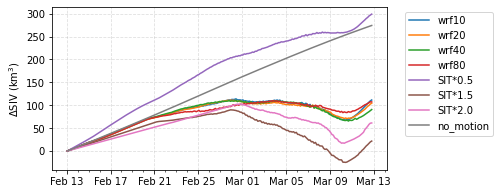

In [17]:
fig, ax = plt.subplots(1,1, figsize = (6,3))
for i, ds in enumerate(dslist):

    o = IceGrowth(ds.copy(), bbox)
    ds_sel = o.dataset
    
    time = ds_sel['time'].time.values.astype('datetime64[ms]').astype('O')
    
    sivBS = ds_sel['sit']*cell_area # in m3
    sivBS_total = sivBS.sum(dim=("x", "y"))*1e-9 
    
    sivBS_rel = sivBS_total - sivBS_total[0] # change relative to start of simul
    
    ax.plot(time, sivBS_rel, label=labelstr[i])
    
plt.ylabel(r'$\Delta$SIV (km$^3$)')
days = mdates.DayLocator()  # every day
dtFmt = mdates.DateFormatter('%b %d') # define the formatting     
ax.xaxis.set_major_formatter(dtFmt)
ax.xaxis.set_minor_locator(days)
ax.grid(linestyle='--', alpha=0.4)
ax.legend(loc='upper left', bbox_to_anchor=(1.04,1))

# save figure
figname = os.path.join(outpath_plots,
      '%s%s' % (outpath_plots, 'dSIV_beaufort_all-expts.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')

# Plot total thermodynamic growth

loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_01_wrf10/outputs/Moorings.nc
Apply bbox
output frequency  8.0
newice
del_vi_thin
del_vi
loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_02_wrf20/outputs/Moorings.nc
Apply bbox
output frequency  8.0
newice
del_vi_thin
del_vi
loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_03_wrf40/outputs/Moorings.nc
Apply bbox
output frequency  8.0
newice
del_vi_thin
del_vi
loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_04_wrf80/outputs/Moorings.nc
Apply bbox
output frequency  8.0
newice
del_vi_thin
del_vi
loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_05_wrf10-sitx

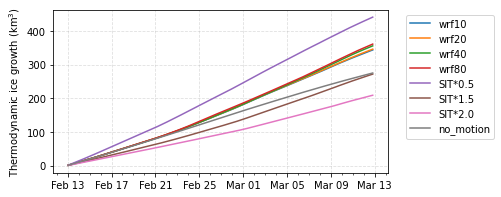

In [20]:
fig, ax = plt.subplots(1,1, figsize = (6,3))
for i, ds in enumerate(dslist):
    print("loading", files[i])

    # make a copy
    Igrowth = IceGrowth(ds.copy(), bbox)
    
    # fix timestep
    Igrowth.fix_growthrate()
    
    # calculate ice volume growth
    dVol = Igrowth.calc_vol_growth(cell_area)
    
    # total ice volume growth (cumulative sum)
    dVol['newice_tot']  = dVol['newice'].cumsum(axis=0)*1e-9 # in km3
    dVol['youngice_tot'] = dVol['del_vi_thin'].cumsum(axis=0)*1e-9 
    dVol['oldice_tot'] = dVol['del_vi'].cumsum(axis=0)*1e-9  
    
    # Calculate the total change in volume in leads and pack-ice combined
    dVol_total = dVol['newice_tot'] + dVol['youngice_tot'] + dVol['oldice_tot']
    
    ax.plot(time, dVol_total, label=labelstr[i])
    
ax.set_ylabel(r'Thermodynamic ice growth (km$^3$)')
days = mdates.DayLocator()  # every day
dtFmt = mdates.DateFormatter('%b %d') # define the formatting     
ax.xaxis.set_major_formatter(dtFmt)
ax.xaxis.set_minor_locator(days)
ax.grid(linestyle='--', alpha=0.4)
ax.legend(loc='upper left', bbox_to_anchor=(1.04,1))

# save figure
figname = os.path.join(outpath_plots,
      '%s%s' % (outpath_plots, 'ThermoVolGrowth_beaufort_all-expts.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')
    

loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_01_wrf10/outputs/Moorings.nc
Apply bbox
output frequency  8.0
newice
del_vi_thin
del_vi
loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_02_wrf20/outputs/Moorings.nc
Apply bbox
output frequency  8.0
newice
del_vi_thin
del_vi
loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_03_wrf40/outputs/Moorings.nc
Apply bbox
output frequency  8.0
newice
del_vi_thin
del_vi
loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_04_wrf80/outputs/Moorings.nc
Apply bbox
output frequency  8.0
newice
del_vi_thin
del_vi
loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_05_wrf10-sitx

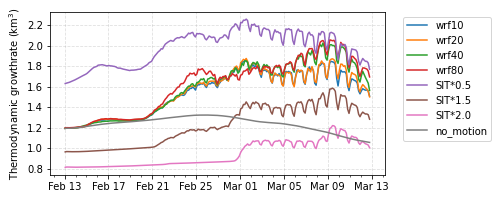

In [21]:
fig, ax = plt.subplots(1,1, figsize = (6,3))
for i, ds in enumerate(dslist):
    print("loading", files[i])

    # make a copy
    Igrowth = IceGrowth(ds.copy(), bbox)
    
    # fix timestep
    Igrowth.fix_growthrate()
    
    # calculate ice volume growth
    dVol = Igrowth.calc_vol_growth(cell_area)
    
    # ice volume growth rate 
    growthrate = (dVol['newice'] + dVol['del_vi_thin'] + dVol['del_vi'])*1e-9
    
    ax.plot(time, growthrate, label=labelstr[i])
    
ax.set_ylabel(r'Thermodynamic growthrate (km$^3$)')
days = mdates.DayLocator()  # every day
dtFmt = mdates.DateFormatter('%b %d') # define the formatting     
ax.xaxis.set_major_formatter(dtFmt)
ax.xaxis.set_minor_locator(days)
ax.grid(linestyle='--', alpha=0.4)
ax.legend(loc='upper left', bbox_to_anchor=(1.04,1))

# save figure
figname = os.path.join(outpath_plots,
      '%s%s' % (outpath_plots, 'ThermoVolGrowthrate_beaufort_all-expts.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')